# Author: Mike Bardwell, 2018
*code derived from Tensorflows Boston Housing example*

In a *regression* problem, we aim to predict the output of a continuous value. 

This notebook builds a model to predict the nodal voltages based on nodal loading over time. To do this, we'll provide the model with some data points calculated using a Newton-Raphson power flow method.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


1.9.0


## Run Power Flow Simulation

C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\site-packages\pypsa\components.py:758: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  keys=self.passive_branch_components)


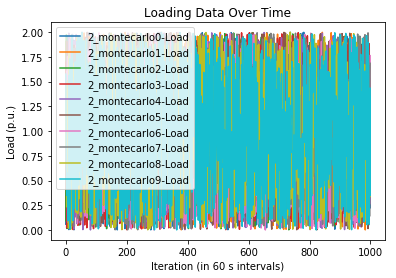

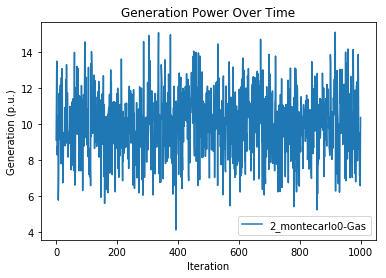

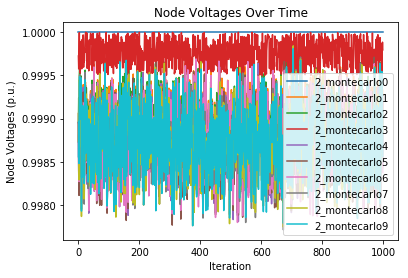

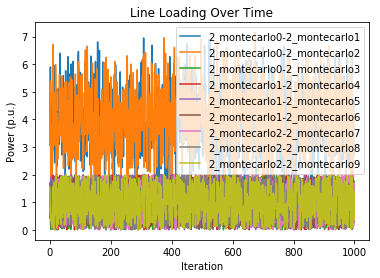

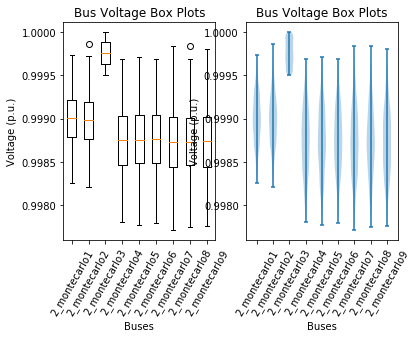

In [9]:
from powerflowsim import PowerFlowSim

no_timestamps = 1000

pfs = PowerFlowSim(no_timestamps, 'radial',  '../_configs/montecarlo10.json')
pfs.nrPfSim(showall = True)

## Training and Test Sets

In [10]:
# split dataset into training and test sets. Do not shuffle (potential historical dependance for powerflow)

train_percentange = 0.7
split_index = int(train_percentange * len(pfs.nodeloads))

train_data = pfs.nodeloads[0:split_index]
pfs.nodevoltages = pfs.nodevoltages.T[1:].T # remove slack node (voltage is always 1.0 p.u.)
train_labels = pfs.nodevoltages[0:split_index]

test_data = pfs.nodeloads[split_index+1:]
test_labels = pfs.nodevoltages[split_index+1:]

## Examples and features 

In [11]:
print("Training set: {}".format(train_data.shape))  # (number of examples, number of features) 
print("Testing set:  {}".format(test_data.shape))  # (number of examples, number of labels) 
print("Testing set:  {}".format(train_labels.shape))
print("Testing set:  {}".format(test_labels.shape))

Training set: (700, 10)
Testing set:  (299, 10)
Testing set:  (700, 9)
Testing set:  (299, 9)


Use the [pandas](https://pandas.pydata.org) library to display the first few rows of the dataset in a nicely formatted table:

In [12]:
import pandas as pd

df = pd.DataFrame(train_data)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.058177,1.906735,0.847291,1.098473,0.423893,0.419143,1.009088,0.905626,0.852161,1.575902
1,1.063786,1.302509,0.088891,1.699660,1.260336,1.340814,1.241703,0.695858,1.164215,1.090302
2,1.428258,1.769889,1.975186,0.766097,1.461987,1.650983,1.006619,1.265958,1.450864,0.686154
3,1.008951,1.794124,0.761341,0.019725,0.921679,1.910862,0.644834,0.631301,0.233526,0.351082
4,1.042560,0.480894,0.014502,1.652636,1.448024,0.896157,1.604933,0.366542,0.772210,0.453990


### Labels

Print a few labels (calculated voltage at each node per timestamp)

In [13]:
print(train_labels[0:10])  # Display first 10 entries

[[0.99905879 0.99895261 0.99972527 0.9989527  0.99895388 0.99880618
  0.99872588 0.99873927 0.99855798]
 [0.99871055 0.99923894 0.99957481 0.99839491 0.99837474 0.99839958
  0.99906479 0.99894753 0.99896604]
 [0.99852363 0.99865221 0.99980842 0.99815739 0.99811001 0.99827151
  0.99833515 0.99828881 0.9984804 ]
 [0.99867889 0.99950525 0.99999507 0.99844809 0.9982002  0.99851743
  0.99934731 0.99944683 0.99941742]
 [0.99888997 0.99959783 0.99958658 0.99852736 0.9986656  0.99848804
  0.99950614 0.99940464 0.99948427]
 [0.99909408 0.99945068 0.99971316 0.99891394 0.9989521  0.9987031
  0.99934482 0.99924618 0.99930691]
 [0.99902951 0.99905619 0.99952566 0.99900919 0.99864885 0.99858999
  0.9989718  0.99867785 0.99899207]
 [0.99928191 0.9994399  0.99989278 0.99889561 0.99925822 0.99923782
  0.9991844  0.99923977 0.99939723]
 [0.9994886  0.99949477 0.99982653 0.99946991 0.99942015 0.99917567
  0.9994302  0.99939454 0.99947149]
 [0.99911682 0.99918693 0.99980827 0.99874511 0.99890473 0.998904

## Reset the model (for reruns)

In [14]:
tf.reset_default_graph()

## Create the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [15]:
def build_model():
  model = keras.Sequential()
  model.add(keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
  model.add(keras.layers.Dropout(0.2))
#   model.add(keras.layers.Dense(64, activation=tf.nn.relu))
#   model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(train_labels.shape[1]))

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) #categorical_crossentropy
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 1,289
Trainable params: 1,289
Non-trainable params: 0
_________________________________________________________________


## Train the model

The model is trained for epochs equal to the number of inputted timestamps. The training and validation accuracy is recorded in the `history` object.

In [16]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = no_timestamps

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.

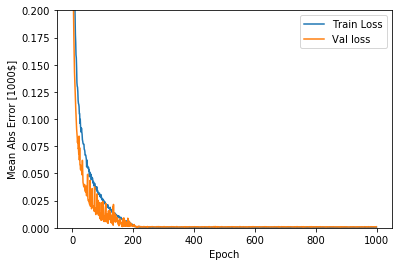

In [17]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,0.2])

plot_history(history)

Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a *callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

TensorBoard log filetime: 1541172604

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................

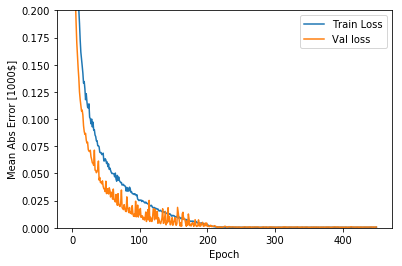

In [18]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

# Add tbCallBack. Use tensorboard --logdir ./logs in command window to open
import time
filetime = str(int(time.time())); print('TensorBoard log filetime:', filetime)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs/' + filetime, histogram_freq=0,  
                                          write_graph=True, write_images=True)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot(), tbCallBack])

plot_history(history)

The graph shows the average error. Is this good? Remember it is the mean abs error with respect to voltages in per unit, so MAE values should not be very large.

Let's see how did the model performs on the test set:

In [19]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:7.5f}".format(mae))

Testing set Mean Abs Error: 0.00083


## Predict

Finally, predict some node voltages using data in the testing set:

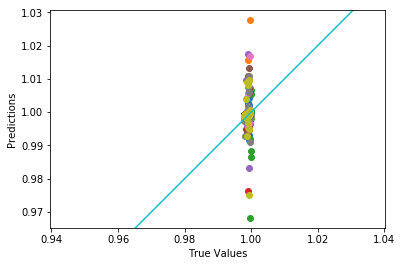

In [26]:
test_predictions = model.predict(test_data)

plt.plot(test_labels, test_predictions, 'o')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([0.98, 1.0])
plt.ylim(plt.ylim())
_ = plt.plot([0, 2],[0,2])


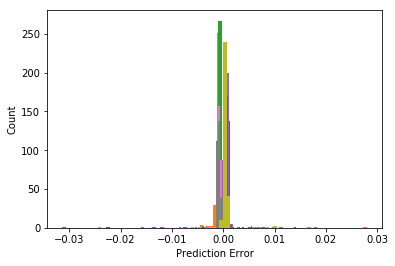

In [21]:
error = test_predictions - test_labels

for i in range(len(error[0])):
    plt.hist(error.T[i], bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

## Save Model

In [22]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When input data features have values with different ranges, each feature should be scaled independently.
* If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.